In [1]:
%%javascript
IPython.OutputArea.auto_scroll_threshold = 9999;

<IPython.core.display.Javascript object>

In [2]:
import datetime
import os
import matplotlib
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from notebook_shared import utils

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller

from pandas import Series

import seaborn as sns
sns.set()
matplotlib.style.use('seaborn-colorblind')

INPUT_FILE = "dataset"
FSIZE = "full"

df = pd.read_parquet(utils.get_dataset_path(INPUT_FILE, FSIZE))

In [3]:
def get_timezone(dataset, provider, region):
    timezones = dataset[ (dataset['provider'] == provider) & (dataset['region'] == region) ]['timezone'].unique()
    
    if (len(timezones)) != 1:
        print(timezones)
        raise ValueError()
    timezone = timezones[0]
    return timezone

In [4]:
from statsmodels.tsa.seasonal import seasonal_decompose
def plot_decompose(decomposed_data, timezone,
                   start = None, end = None,
                   figsize=(20,8), dtfmt='%d/%m',
                   xtickstepsize=2, xticksrotation=45):
        
    with plt.rc_context():
        plt.rc("figure", figsize=figsize)

        fig, axis = plt.subplots(figsize=(24,12), sharex=True, nrows=4)
        
        print(start, type(start))
        
        # Set xlims when not set:
        if (start is None) or (start is not None and type(start) is not str):
            start = int(decomposed_data.observed.index.min().timestamp() / 24 / 60 / 60)
        else:
            start = int(pd.Timestamp(start).timestamp()  / 24 / 60 / 60)
            
        if (end is None) or (end is not None and type(end) is not str):
            end = int(decomposed_data.observed.index.max().timestamp() / 24 / 60 / 60)
        else:
            end = int(pd.Timestamp(end).timestamp()  / 24 / 60 / 60)
        
        # Plot Components
        axis[0].plot(decomposed_data.observed)
        plt.setp(axis[0], ylabel='Observed')

        axis[1].plot(decomposed_data.resid)
        plt.setp(axis[1], ylabel='Residuals')
        
        axis[2].plot(decomposed_data.trend)
        plt.setp(axis[2], ylabel='Trend')
        
        axis[3].plot(decomposed_data.seasonal)
        plt.setp(axis[3], ylabel='Seasonal')
        
        hours = mdates.HourLocator(interval=12) #or use interval
        hours.MAXTICKS = 3392
        import pytz
        
        h_fmt = mdates.DateFormatter(dtfmt, tz=pytz.timezone(timezone))
        
        for ax in axis:
            ax.set_xlim(start, end)
            ax.xaxis.set_major_locator(hours)
            ax.xaxis.set_major_formatter(h_fmt)
            ax.xaxis.set_ticks(np.arange(start, end, xtickstepsize))
            ax.xaxis_date(tz=timezone)

        fig.autofmt_xdate()
        plt.xticks(rotation=xticksrotation)
        return decomposed_data

In [5]:
provider = 'AZURE'
region =  'australiaeast'

In [6]:
# Prints the results of augmented Dickey–Fuller test (ADF)
# h0 -> time series is non-stationary --> data is time-dependent
# h1 -> time series is stationary --> data is NOT time-dependent
# rejection criterions:
# if p-value is less than x% (e.g. 5)
# of if test statistic is lower then critical value reject h0


# The null hypothesis of the Augmented Dickey-Fuller is that there is a unit root,
# with the alternative that there is no unit root.
# If the pvalue is above a critical size, then we cannot reject that there is a unit root.

# The p-values are obtained through regression surface approximation from MacKinnon 1994
# but using the updated 2010 tables.
# If the p-value is close to significant, then the critical values should be used to judge whether to reject the null.

def print_adf(test):
    test_statistic = test[0]
    crit_value_1p = test[4]['1%']
    crit_value_5p = test[4]['5%']
    tab = {
        "Test Statistic": test_statistic,
        "p Value": test[1],
        "used lag": test[2],
        "nobs": test[3],
        "critical value  1%": crit_value_1p,
        "critical value  5%": crit_value_5p,
        "critical value 10%": test[4]['10%'],
    }
    if test_statistic < crit_value_1p:
        print('H0 can be rejected -> not time-depedent')
    elif test_statistic < crit_value_5p:
        print('H0 can be rejected -> not time-dependent')
    else:
        print('H0 can not be rejected -> potentially time-dependent')
    tabstr = "----ADF Test Results----"
    for k, v in tab.items():
        tabstr += "\n{:<20} {:<15}".format(k, v)
    return tabstr

In [7]:
def decompose(dataset, provider, region, dt_rounding, decompose_period,
              dtfmt='%a %d/%m', adflag=None, xtickstepsize=2, xticksrotation=45, start=None, end=None,
              adf_regression='c', plotstart=None,plotend=None):
    print(provider, region)

    from statsmodels.tsa.stattools import adfuller
    
    if adflag is None:
        autolag = 'AIC'
        maxlag = None
    else:
        autolag = None
        maxlag = adflag
    
    # Slice data for decomposition
    if (start is None) or (start is not None and type(start) is not str):
        startts = dataset['driver_invocation'].min()
    else:
        startts = pd.Timestamp(start)
    if (end is None) or (end is not None and type(end) is not str):
        endts = dataset['driver_invocation'].max()
    else:
        endts = pd.Timestamp(end)

    selected_df = dataset[dataset['driver_invocation'].between(startts, endts, inclusive='both')]
    
    # df_providerregion = selected_df[ (selected_df['provider'] == provider) & (selected_df['region'] == region) ]
    # df_providerregion.insert(0, "driver_invocation_rounded", df_providerregion['driver_invocation'].dt.round(dt_rounding))
    # df_providerregion_runtime_mean = df_providerregion.groupby(['driver_invocation_rounded'])[['runtime']].mean()
    
    # TODO: check how much asfreq changes data
    df_providerregion = selected_df[ (selected_df['provider'] == provider) & (selected_df['region'] == region) ]
    df_providerregion.insert(0, "driver_invocation_rounded", df_providerregion['driver_invocation'].dt.round(dt_rounding))
    df_providerregion_runtime_mean = df_providerregion.groupby(['driver_invocation_rounded'])[['runtime']].mean()
    
    df_providerregion_runtime_mean = df_providerregion_runtime_mean.asfreq(dt_rounding)
    
    # print(df_providerregion_runtime_mean)
    
    # Fill with asfreq with mean
    df_providerregion_runtime_mean = df_providerregion_runtime_mean.fillna(df_providerregion_runtime_mean.mean())
    
    test = adfuller(df_providerregion_runtime_mean['runtime'], maxlag = maxlag, autolag=autolag, regression=adf_regression)
    print(print_adf(test))
    # dfdecomp = seasonal_decompose(df_providerregion_runtime_mean, model='addtive' , period=decompose_period)
    
    from statsmodels.tsa.seasonal import STL
    
    dfdecomp = res = STL(df_providerregion_runtime_mean, robust=True).fit() #seasonal_decompose(df_providerregion_runtime_mean, model='addtive' , period=decompose_period)
    timezone = get_timezone(selected_df, provider, region)
    
    # print(dfdecomp.observed)
    # print(dfdecomp.seasonal)
    
    # If us plotstart and plotend it overrides
    if plotstart is None:
        plotstart = start
    if plotend is None:
        plotend = end
    
    plot_decompose(dfdecomp, timezone, dtfmt=dtfmt, xtickstepsize=xtickstepsize, xticksrotation=xticksrotation,
                   start=plotstart, end=plotend)
    
    utils.plot( ['temporal_analysis', provider, f'decompose_{region}_{dt_rounding}'])
    
    print(provider, region, timezone)
    
    if dt_rounding == "D":
        dt_rounding = 'w'
    
    sdf = pd.DataFrame(dfdecomp.seasonal)
    sdf['hist'] = sdf.index.strftime(f"%{dt_rounding}")
    
    if (dt_rounding == "w"):
        sdf['hist'] = sdf['hist'].replace('0', '7')
    
    # sdf.boxplot('season', by='hist')
    # TODO: PLot based on stuff
    sdf = pd.DataFrame(dfdecomp.seasonal)
    sdf['hist'] = sdf.index.tz_localize('UTC').tz_convert(timezone).strftime(f"%{dt_rounding}")
    
    if (dt_rounding == "w"):
        sdf['hist'] = sdf['hist'].replace('0', '7')
        
    # sdf.boxplot('season', by='hist')
    sdf.boxplot('season', by='hist', showfliers=False)
    utils.plot( ['temporal_analysis', provider, f'decompose_{region}_{dt_rounding}_season_boxplot'])
    
    # TODO: Check value of creating Autocorrelation plot 
    # x = pd.plotting.autocorrelation_plot(df_providerregion_runtime_mean.head(decompose_period))
    # import statsmodels.api as sm
    # https://medium.com/@krzysztofdrelczuk/acf-autocorrelation-function-simple-explanation-with-python-example-492484c32711
    # https://www.statsmodels.org/dev/generated/statsmodels.graphics.tsaplots.plot_acf.html
    # sm.graphics.tsa.plot_acf(df_providerregion_runtime_mean, lags=decompose_period)
    # x = pd.plotting.autocorrelation_plot(df_providerregion_runtime_mean)
    # x.plot()
    # plt.show()
    return dfdecomp

In [8]:
print(str(list(df[df['provider'] == "AZURE"].groupby('provider', observed=True)['region'].unique())))

# idea:
# decompose, then collect and group seasonality by time (do hist for each day)

[['australiaeast', 'brazilsouth', 'centralindia', 'eastus', 'germanywestcentral', 'japaneast', 'uksouth', 'westus', 'westus2']
Categories (29, object): ['ap-northeast-1', 'ap-south-1', 'ap-southeast-2', 'asia-northeast1', ..., 'us-west2', 'us-west4', 'westus', 'westus2']]


AZURE australiaeast
H0 can not be rejected -> potentially time-dependent
----ADF Test Results----
Test Statistic       -3.2949696680094442
p Value              0.17399238738330308
used lag             24             
nobs                 1426           
critical value  1%   -4.379274097326233
critical value  5%   -3.8365376275835597
critical value 10%   -3.5558289642619476
None <class 'NoneType'>


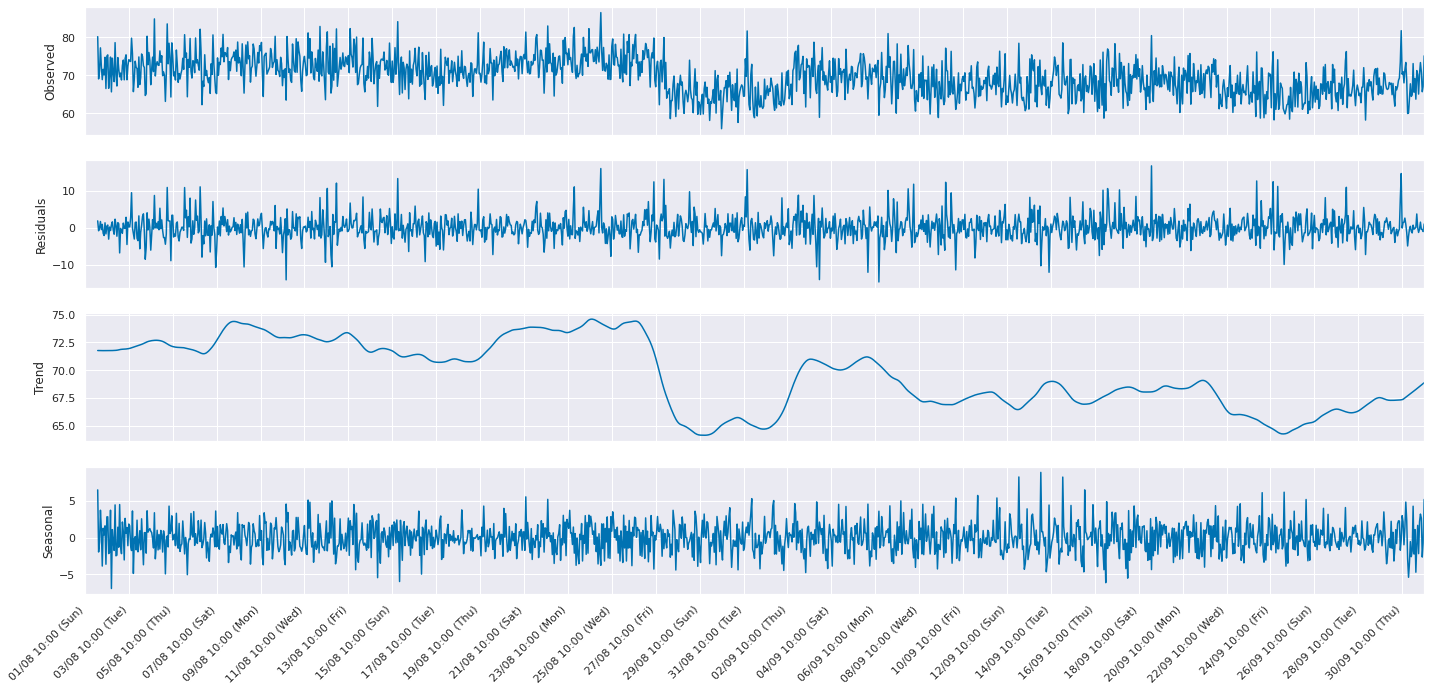

AZURE australiaeast Australia/Sydney


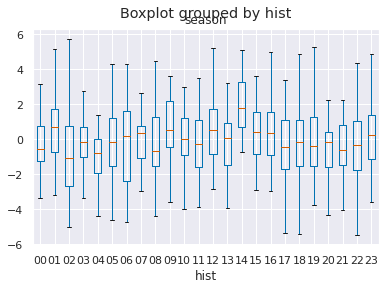

AZURE brazilsouth
H0 can be rejected -> not time-depedent
----ADF Test Results----
Test Statistic       -4.4997523416022025
p Value              0.006522013199975157
used lag             24             
nobs                 1426           
critical value  1%   -4.379274097326233
critical value  5%   -3.8365376275835597
critical value 10%   -3.5558289642619476
None <class 'NoneType'>


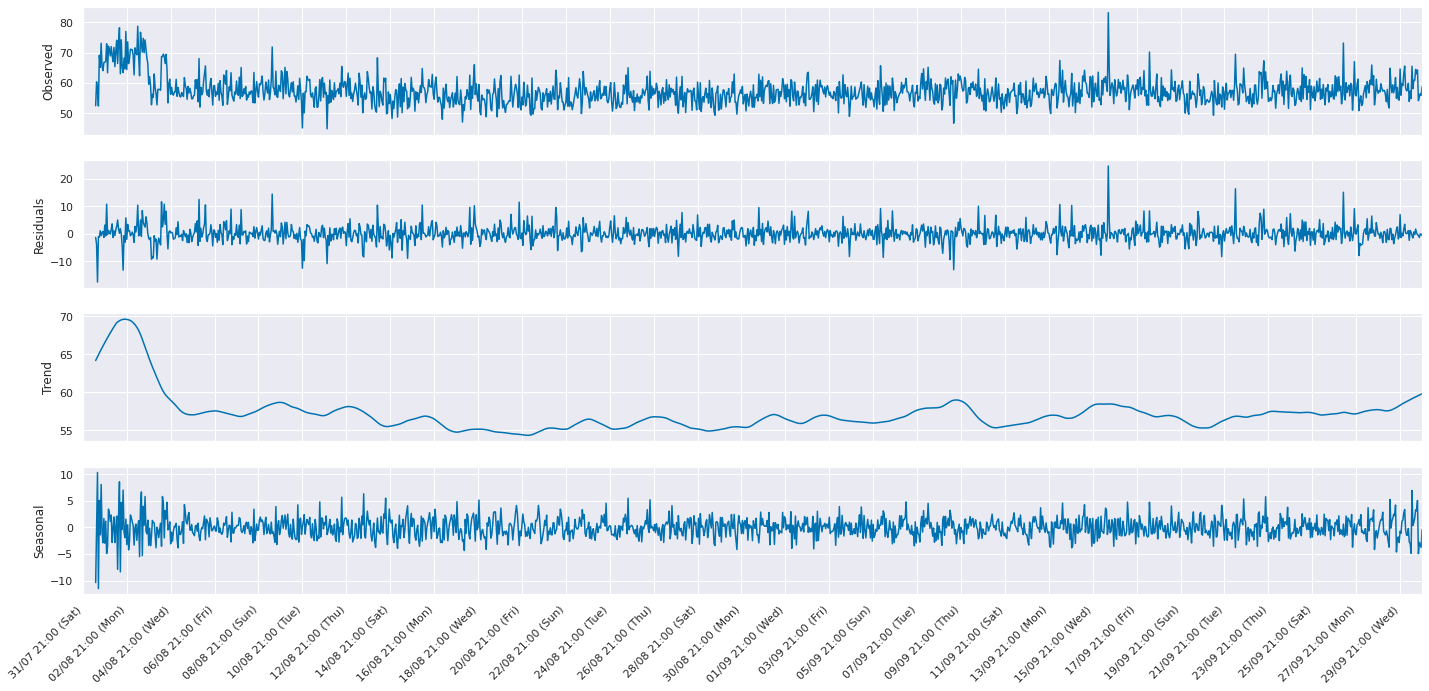

AZURE brazilsouth America/Sao_Paulo


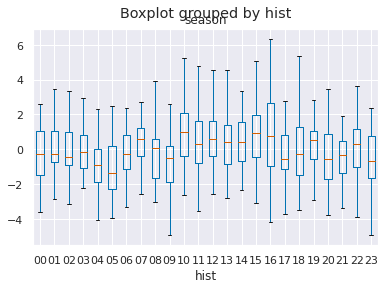

AZURE centralindia
H0 can be rejected -> not time-depedent
----ADF Test Results----
Test Statistic       -5.892868846250795
p Value              2.1270072945994173e-05
used lag             24             
nobs                 1426           
critical value  1%   -4.379274097326233
critical value  5%   -3.8365376275835597
critical value 10%   -3.5558289642619476
None <class 'NoneType'>


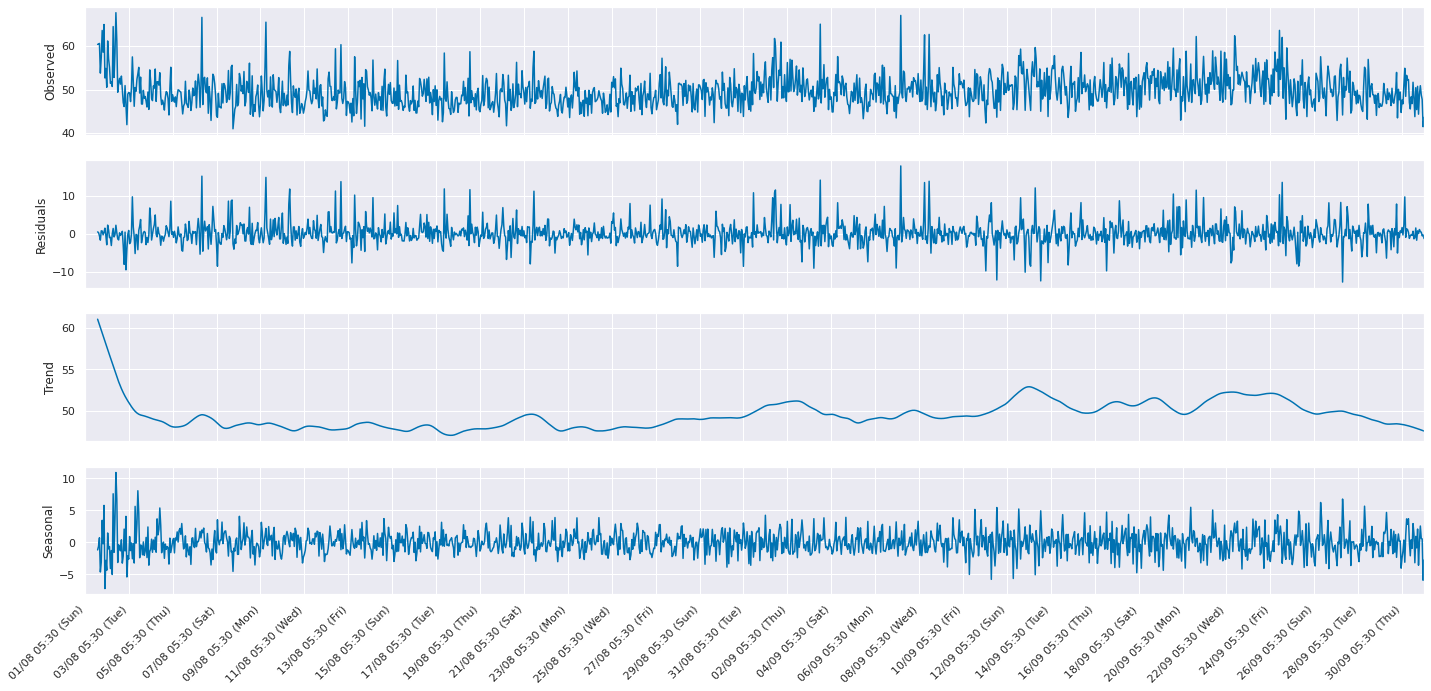

AZURE centralindia Asia/Kolkata


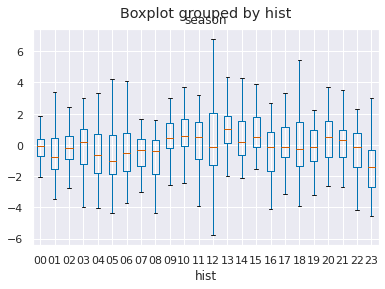

AZURE eastus
H0 can be rejected -> not time-depedent
----ADF Test Results----
Test Statistic       -5.912781958100465
p Value              1.9367686169884285e-05
used lag             24             
nobs                 1426           
critical value  1%   -4.379274097326233
critical value  5%   -3.8365376275835597
critical value 10%   -3.5558289642619476
None <class 'NoneType'>


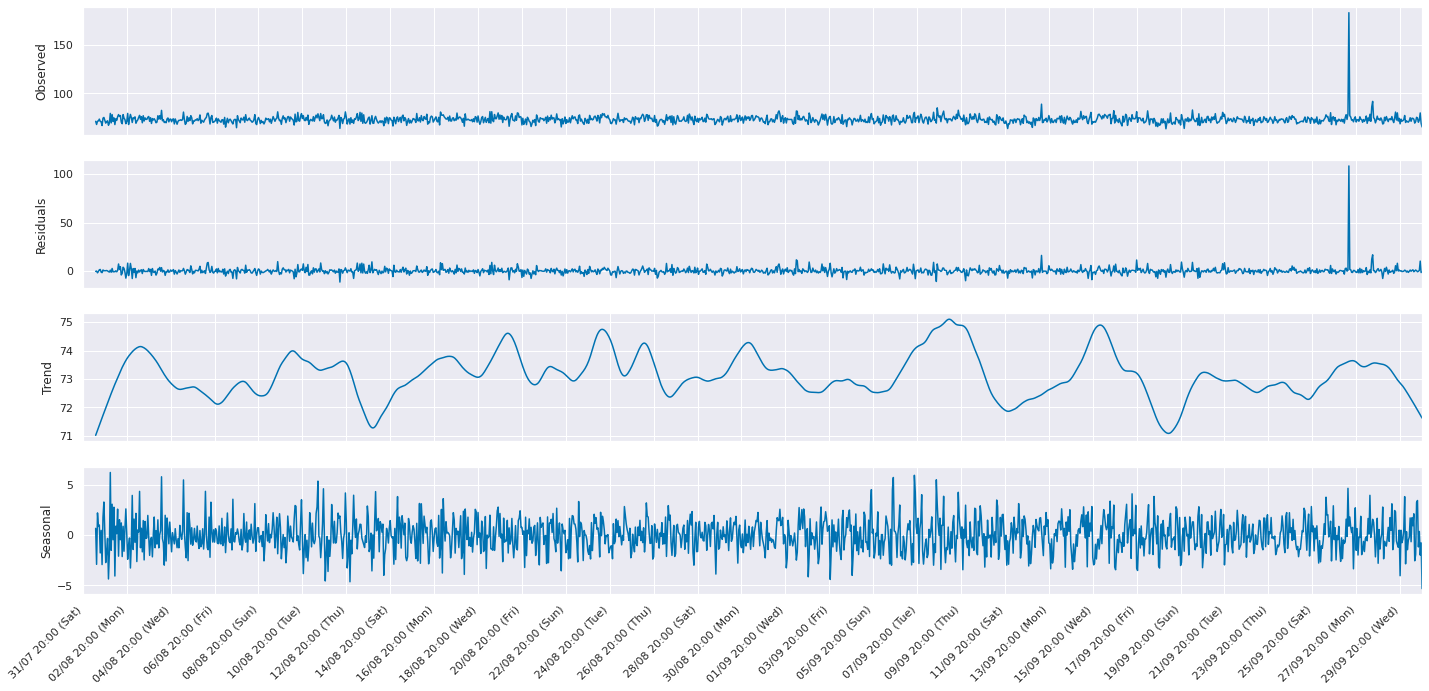

AZURE eastus America/New_York


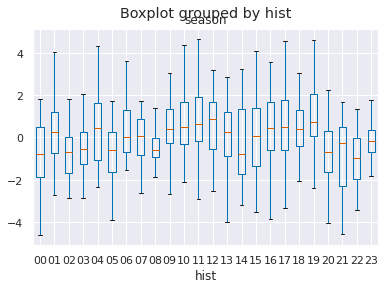

AZURE germanywestcentral
H0 can be rejected -> not time-depedent
----ADF Test Results----
Test Statistic       -5.119257476865481
p Value              0.0006365954772823761
used lag             24             
nobs                 1426           
critical value  1%   -4.379274097326233
critical value  5%   -3.8365376275835597
critical value 10%   -3.5558289642619476
None <class 'NoneType'>


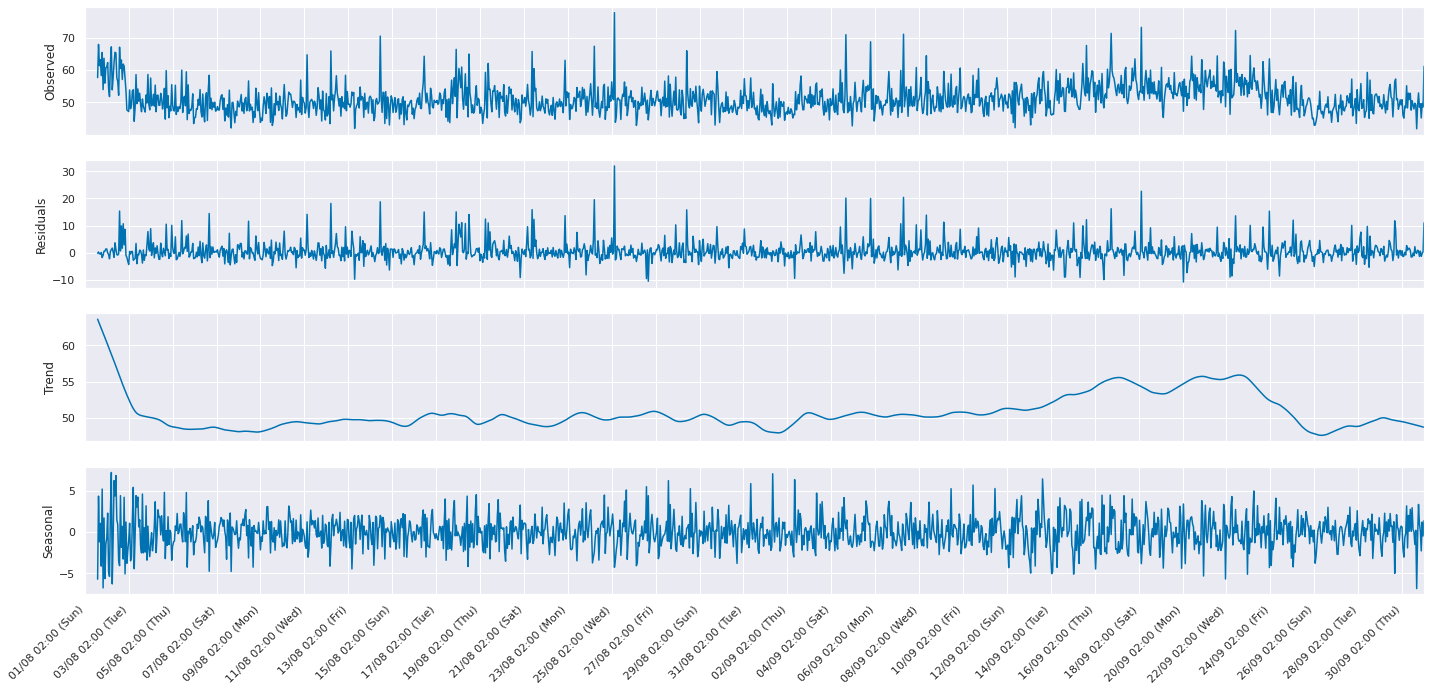

AZURE germanywestcentral Europe/Berlin


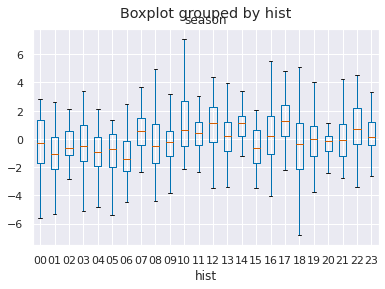

AZURE japaneast
H0 can not be rejected -> potentially time-dependent
----ADF Test Results----
Test Statistic       -2.281206141669859
p Value              0.6894105031708193
used lag             24             
nobs                 1426           
critical value  1%   -4.379274097326233
critical value  5%   -3.8365376275835597
critical value 10%   -3.5558289642619476
None <class 'NoneType'>


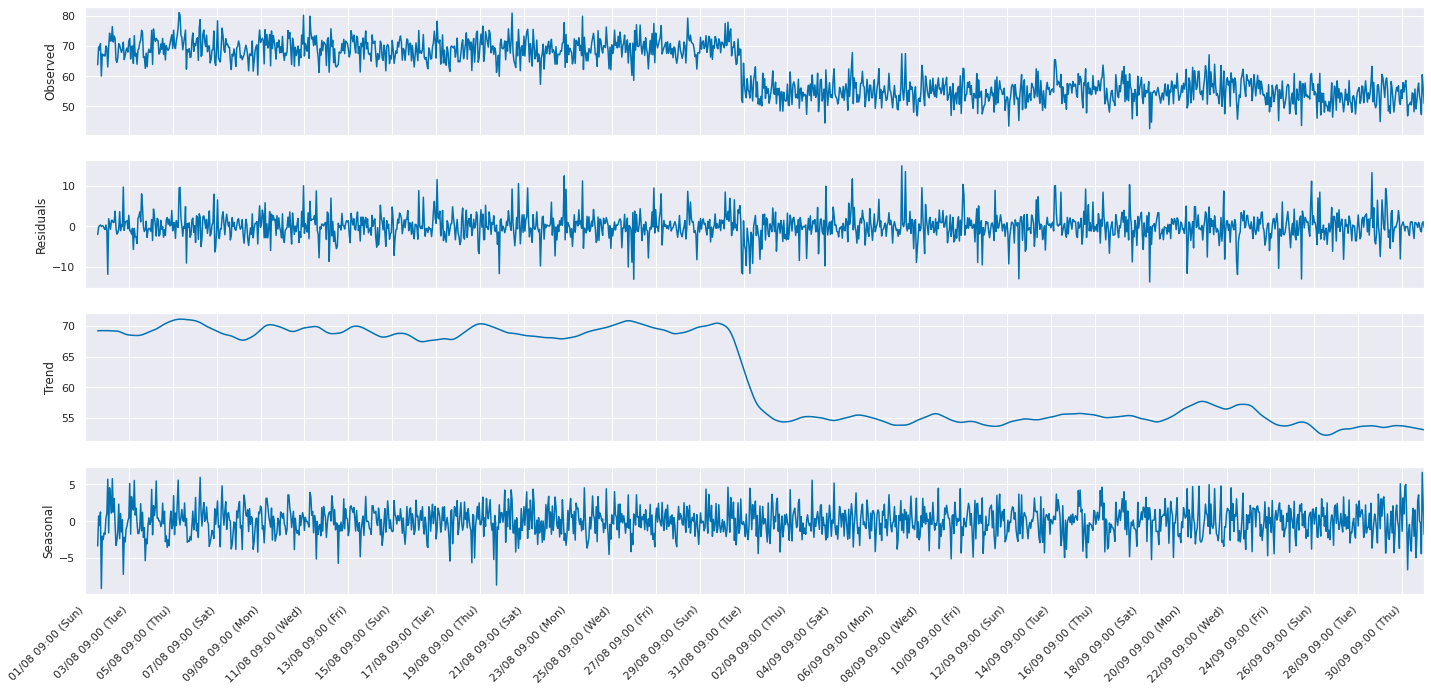

AZURE japaneast Asia/Tokyo


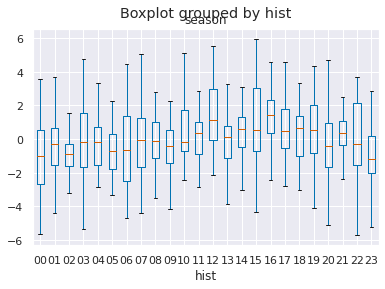

AZURE uksouth
H0 can not be rejected -> potentially time-dependent
----ADF Test Results----
Test Statistic       -3.532761354437969
p Value              0.10485475016127399
used lag             24             
nobs                 1426           
critical value  1%   -4.379274097326233
critical value  5%   -3.8365376275835597
critical value 10%   -3.5558289642619476
None <class 'NoneType'>


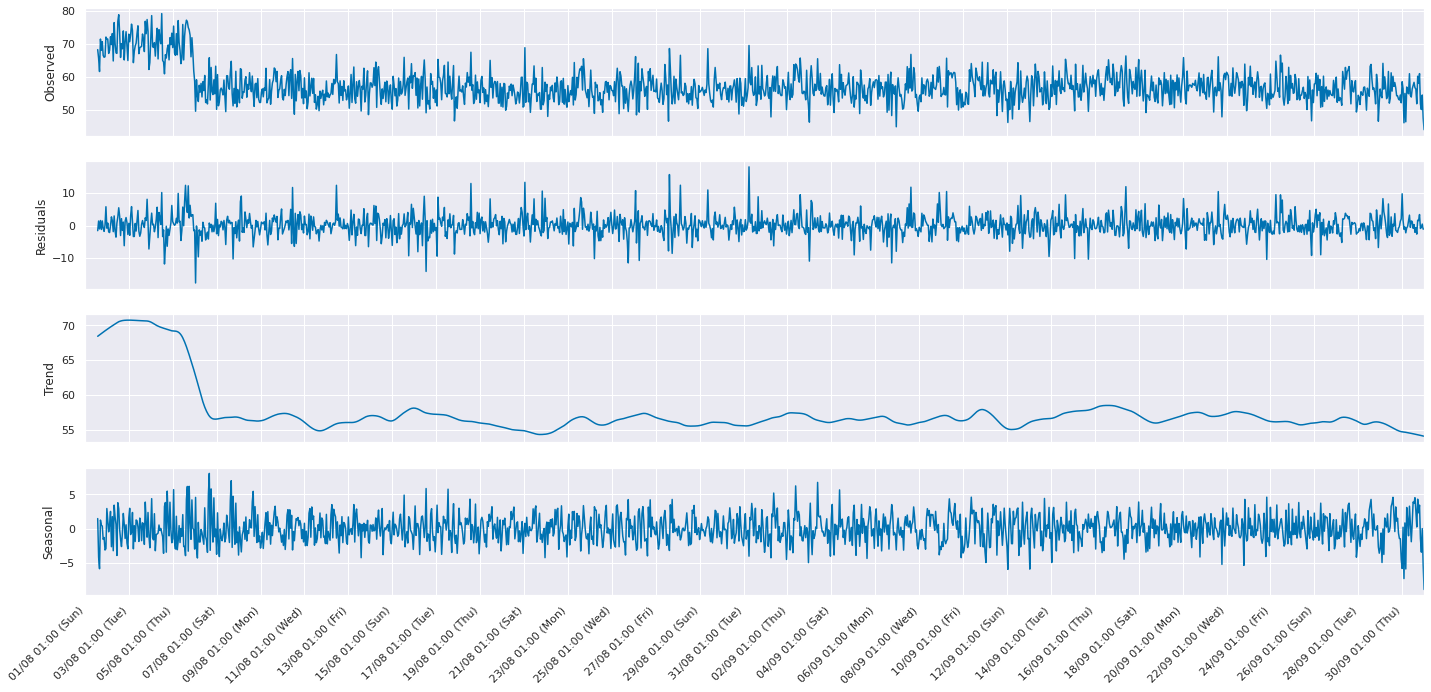

AZURE uksouth Europe/London


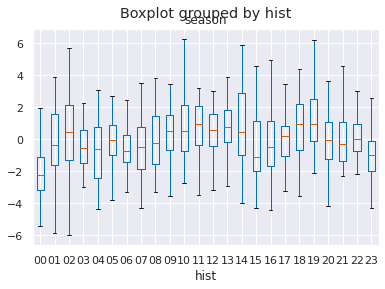

AZURE westus
H0 can be rejected -> not time-depedent
----ADF Test Results----
Test Statistic       -7.6469919642778414
p Value              2.3893574764105226e-09
used lag             24             
nobs                 1426           
critical value  1%   -4.379274097326233
critical value  5%   -3.8365376275835597
critical value 10%   -3.5558289642619476
None <class 'NoneType'>


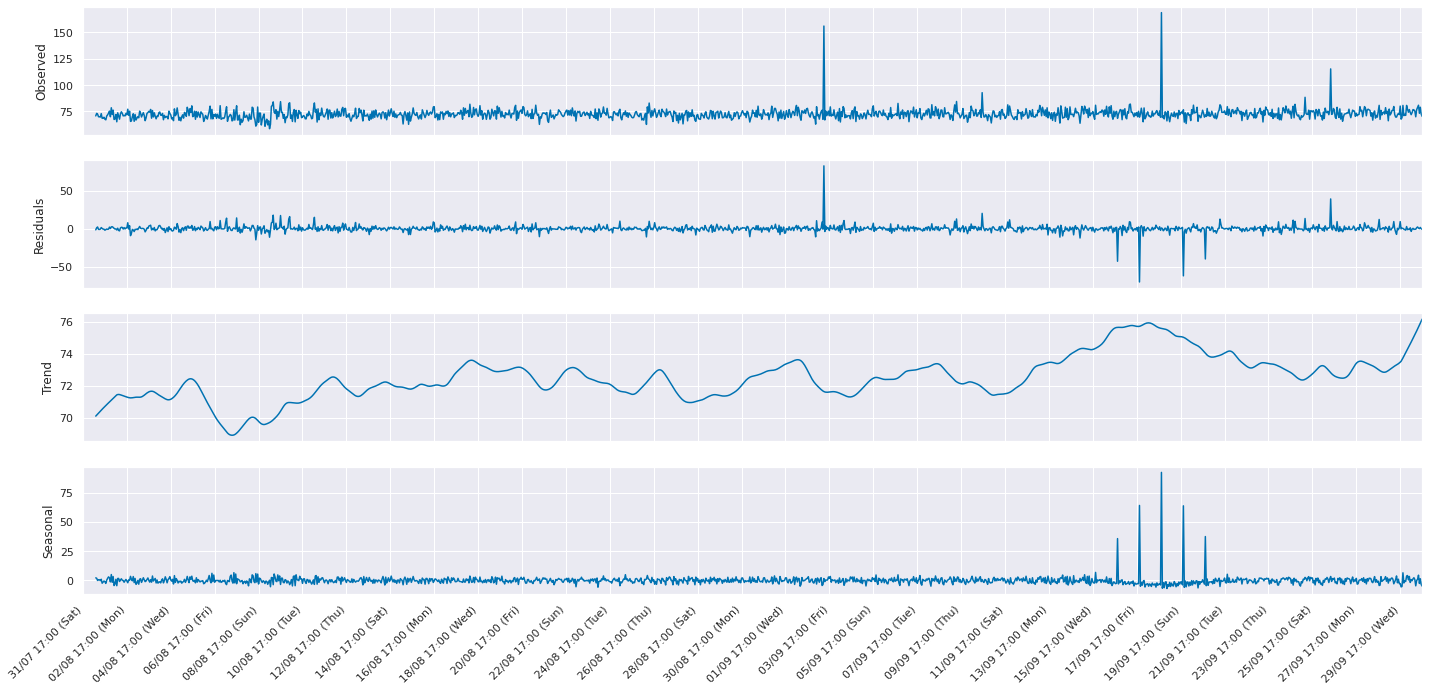

AZURE westus America/Los_Angeles


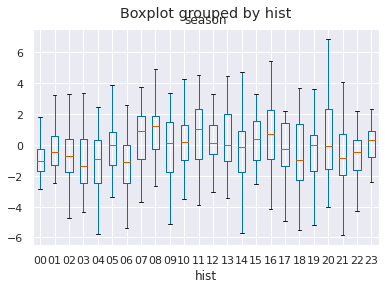

AZURE westus2
H0 can be rejected -> not time-depedent
----ADF Test Results----
Test Statistic       -5.715101659997683
p Value              4.846774476862555e-05
used lag             24             
nobs                 1426           
critical value  1%   -4.379274097326233
critical value  5%   -3.8365376275835597
critical value 10%   -3.5558289642619476
None <class 'NoneType'>


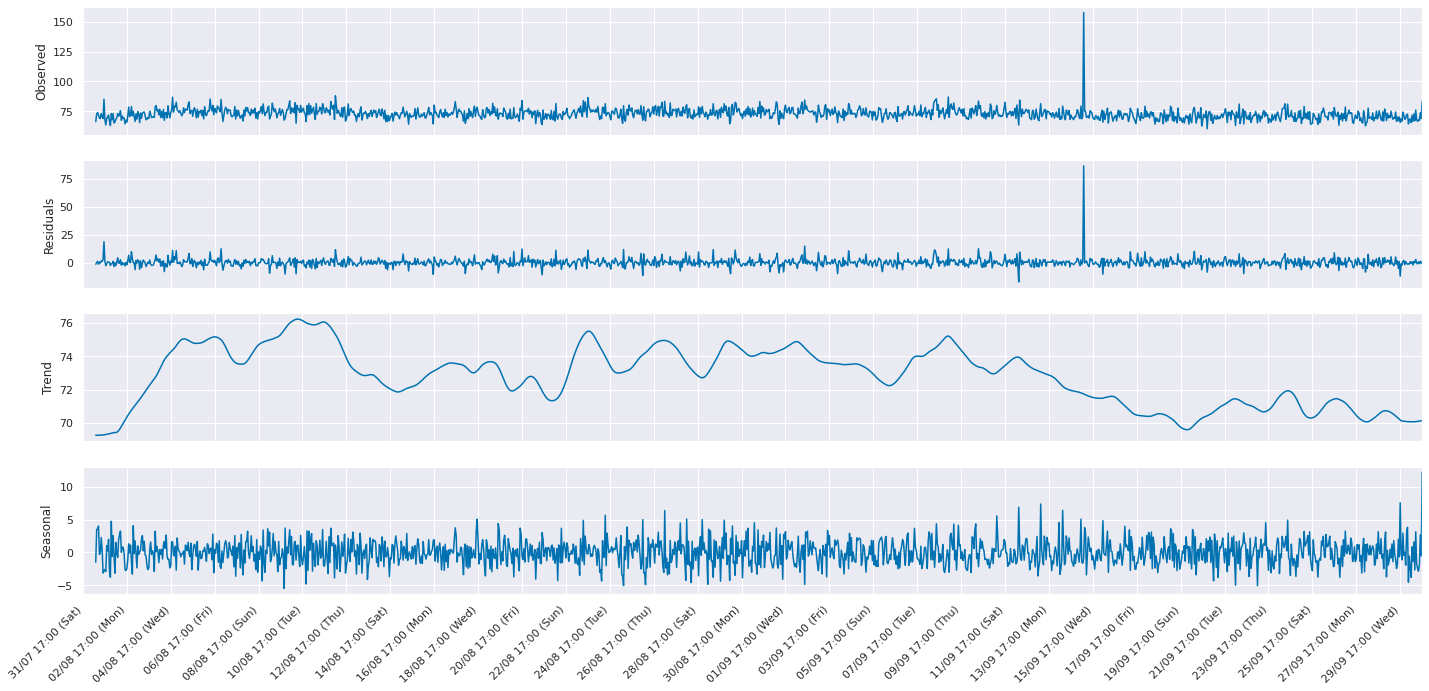

AZURE westus2 America/Los_Angeles


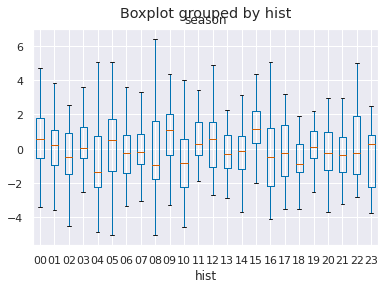

In [9]:
provider = 'AZURE' #AZURE, centralindia, eastus, germanywestcentral, japaneast, uksouth
# ['australiaeast', 'brazilsouth', 'centralindia', 'eastus', 'germanywestcentral', 'japaneast', 'uksouth', 'westus', 'westus2']
regions = ['australiaeast', 'brazilsouth', 'centralindia', 'eastus', 'germanywestcentral', 'japaneast', 'uksouth', 'westus', 'westus2']
for region in regions:
    decomp = decompose(df, provider, region, 'H', 24,
                       adflag=24,
                       #end='2021-08-14',
                       #plotstart='2021-08-03', plotend='2021-08-07',
                       adf_regression='ctt', dtfmt='%d/%m %H:%M (%a)', )#xtickstepsize=0.0421)

In [ ]:
# IDea:
# https://stackoverflow.com/questions/33578342/plot-line-over-boxplot-using-pandas-dataframe

AZURE australiaeast
H0 can not be rejected -> potentially time-dependent
----ADF Test Results----
Test Statistic       -3.2110640043295504
p Value              0.204473008727391
used lag             7              
nobs                 53             
critical value  1%   -4.604770574433928
critical value  5%   -3.9490592323192972
critical value 10%   -3.6246202799626537
None <class 'NoneType'>


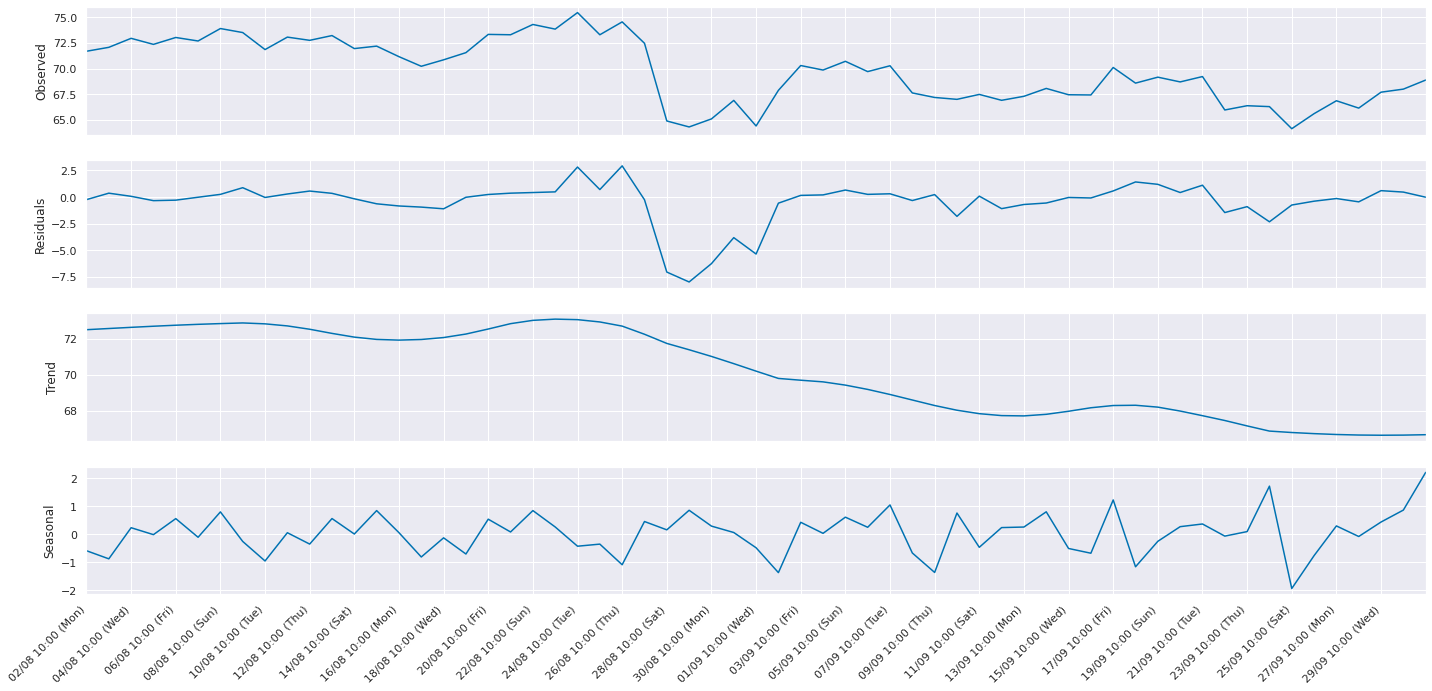

AZURE australiaeast Australia/Sydney


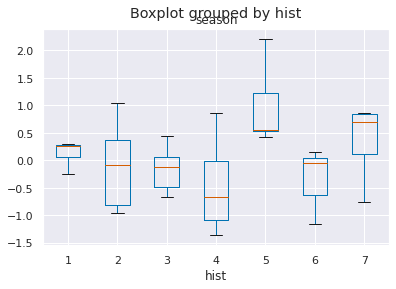

AZURE brazilsouth
H0 can not be rejected -> potentially time-dependent
----ADF Test Results----
Test Statistic       -2.9725801138641734
p Value              0.30841587754601896
used lag             7              
nobs                 53             
critical value  1%   -4.604770574433928
critical value  5%   -3.9490592323192972
critical value 10%   -3.6246202799626537
None <class 'NoneType'>


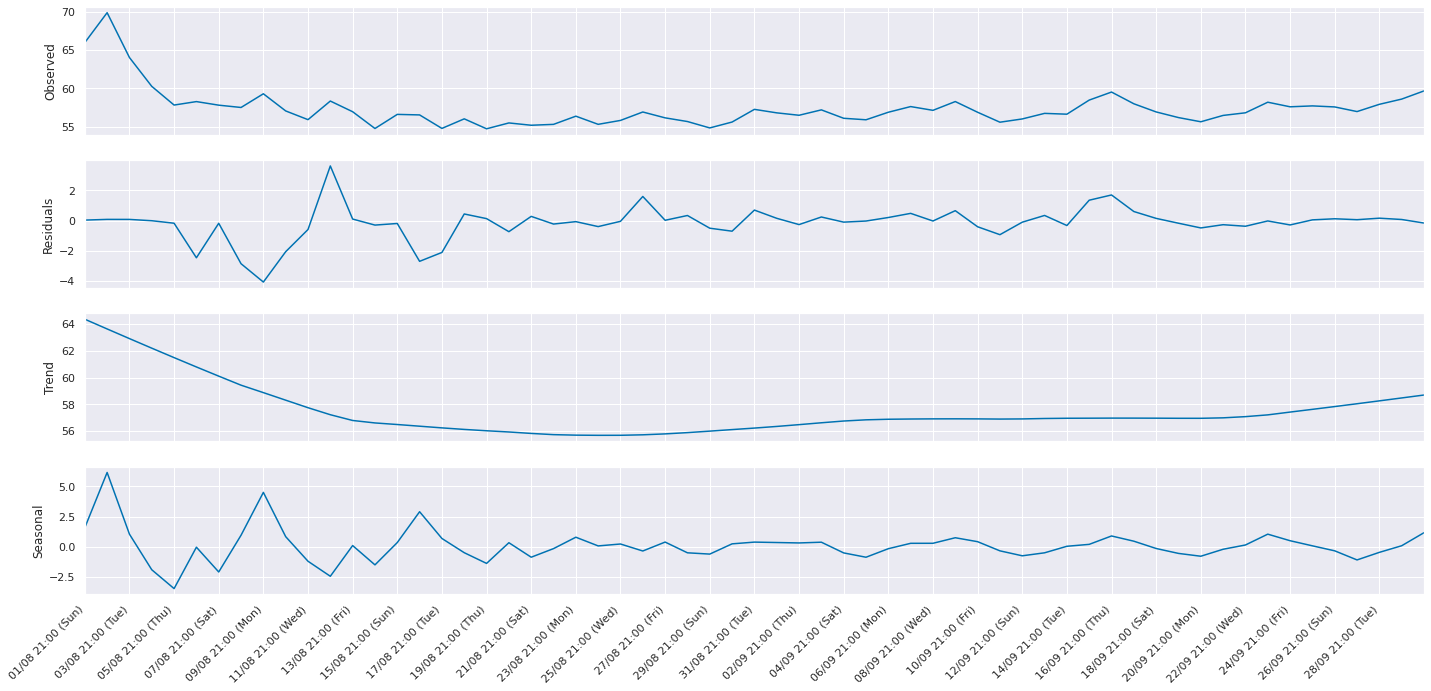

AZURE brazilsouth America/Sao_Paulo


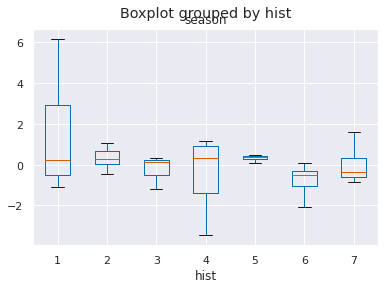

AZURE centralindia
H0 can not be rejected -> potentially time-dependent
----ADF Test Results----
Test Statistic       -1.157478335679631
p Value              0.9793682348681672
used lag             7              
nobs                 53             
critical value  1%   -4.604770574433928
critical value  5%   -3.9490592323192972
critical value 10%   -3.6246202799626537
None <class 'NoneType'>


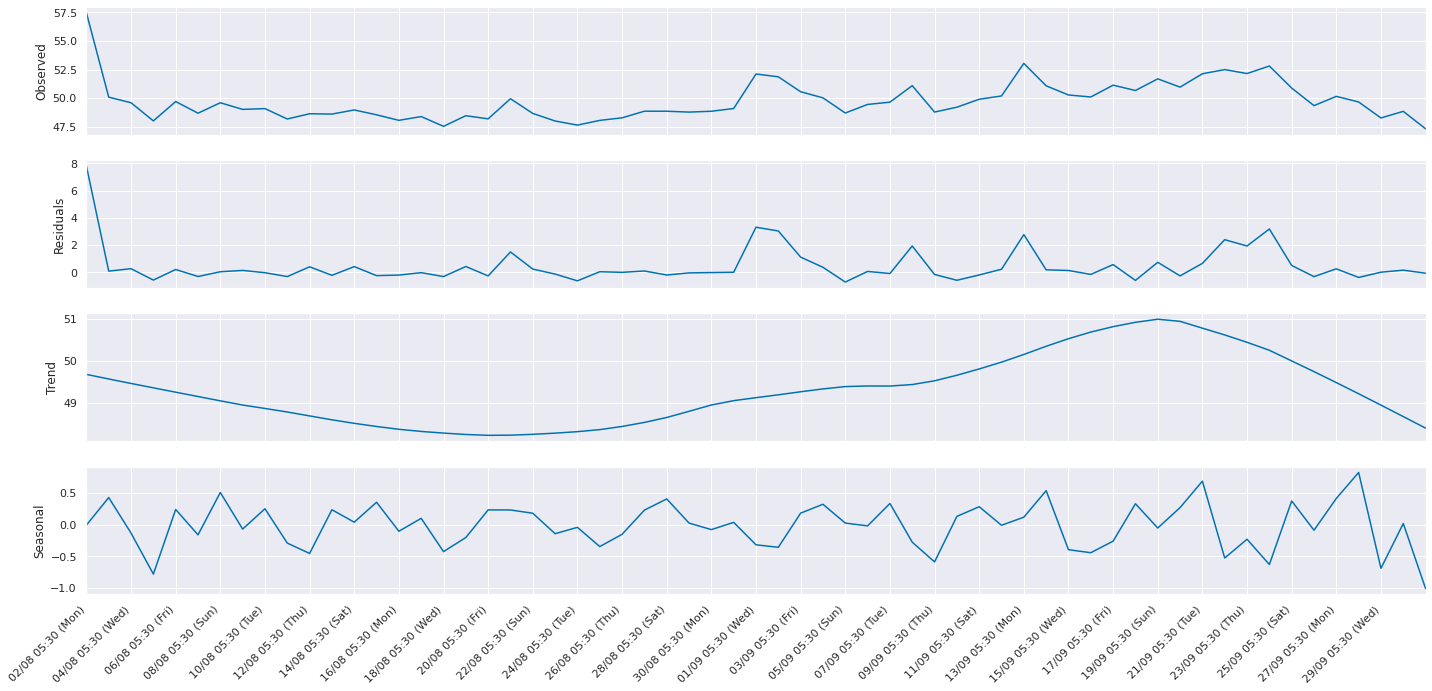

AZURE centralindia Asia/Kolkata


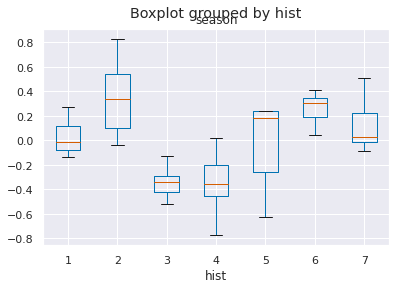

AZURE eastus
H0 can not be rejected -> potentially time-dependent
----ADF Test Results----
Test Statistic       -1.6916156631325663
p Value              0.9099433135374317
used lag             7              
nobs                 53             
critical value  1%   -4.604770574433928
critical value  5%   -3.9490592323192972
critical value 10%   -3.6246202799626537
None <class 'NoneType'>


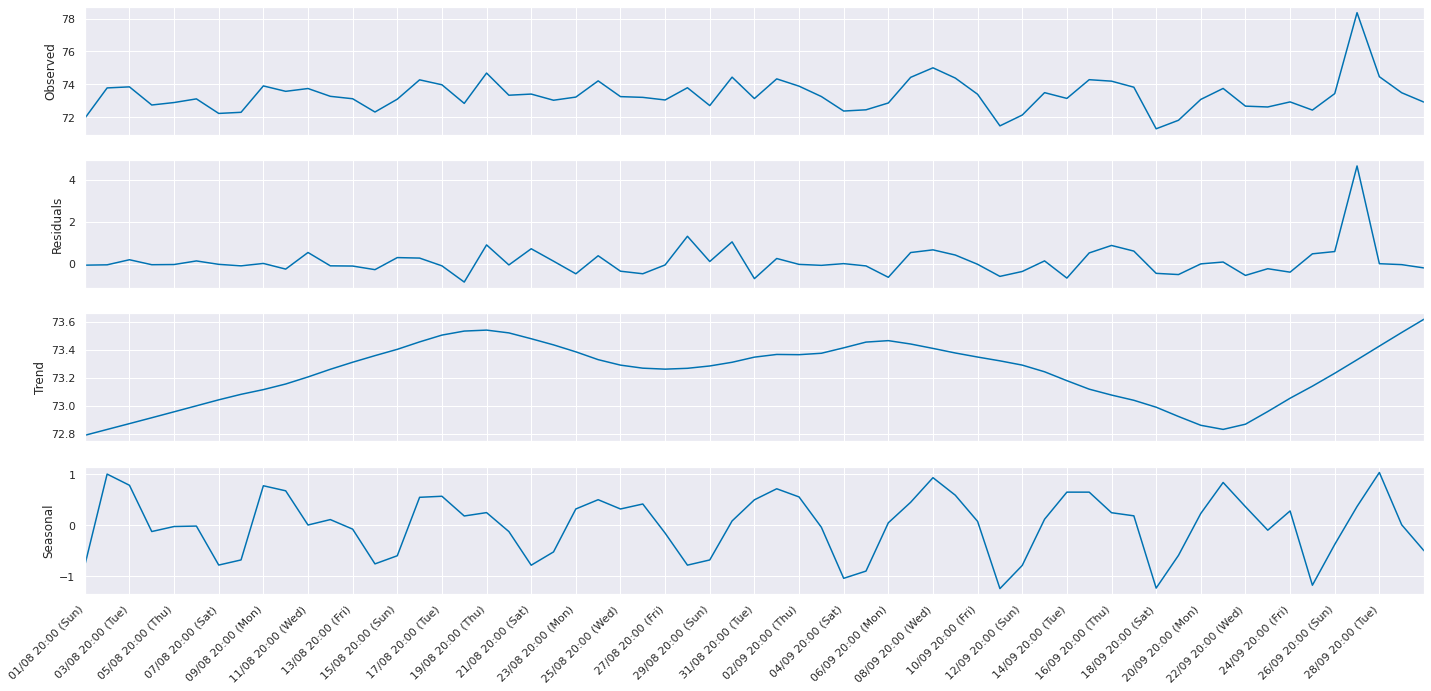

AZURE eastus America/New_York


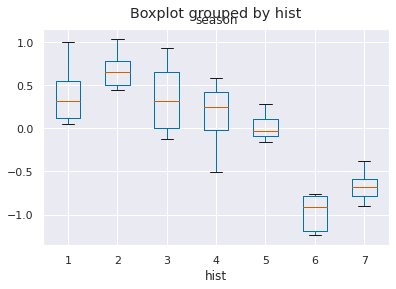

AZURE germanywestcentral
H0 can not be rejected -> potentially time-dependent
----ADF Test Results----
Test Statistic       -1.9069593534996596
p Value              0.8500451745901958
used lag             7              
nobs                 53             
critical value  1%   -4.604770574433928
critical value  5%   -3.9490592323192972
critical value 10%   -3.6246202799626537
None <class 'NoneType'>


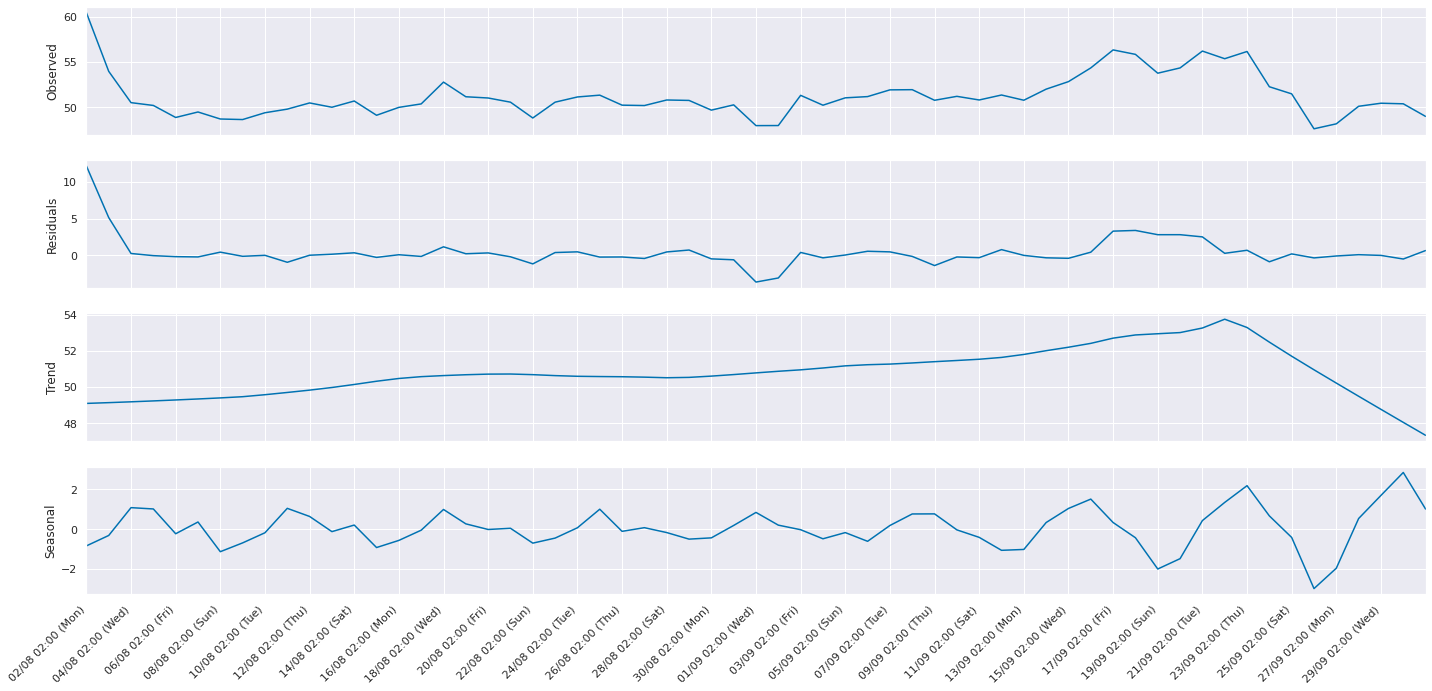

AZURE germanywestcentral Europe/Berlin


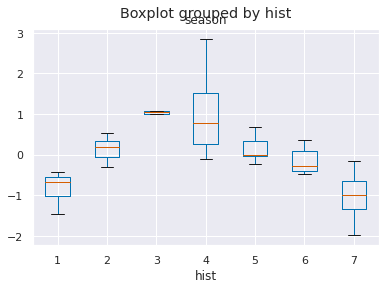

AZURE japaneast
H0 can not be rejected -> potentially time-dependent
----ADF Test Results----
Test Statistic       -2.1564047184566775
p Value              0.7505621821016702
used lag             7              
nobs                 53             
critical value  1%   -4.604770574433928
critical value  5%   -3.9490592323192972
critical value 10%   -3.6246202799626537
None <class 'NoneType'>


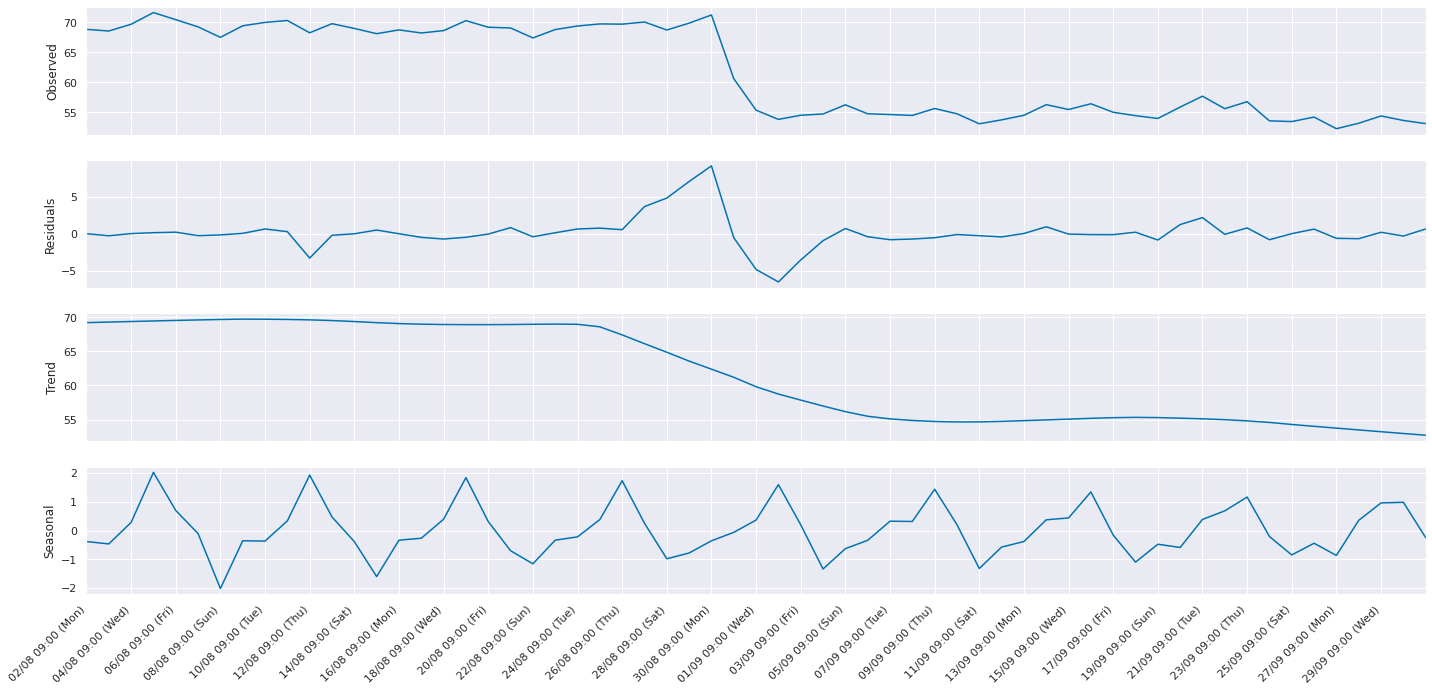

AZURE japaneast Asia/Tokyo


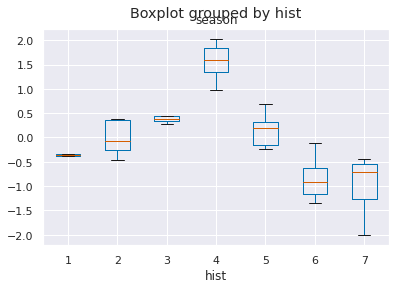

AZURE uksouth
H0 can not be rejected -> potentially time-dependent
----ADF Test Results----
Test Statistic       -2.6641969586194025
p Value              0.47477695492124894
used lag             7              
nobs                 53             
critical value  1%   -4.604770574433928
critical value  5%   -3.9490592323192972
critical value 10%   -3.6246202799626537
None <class 'NoneType'>


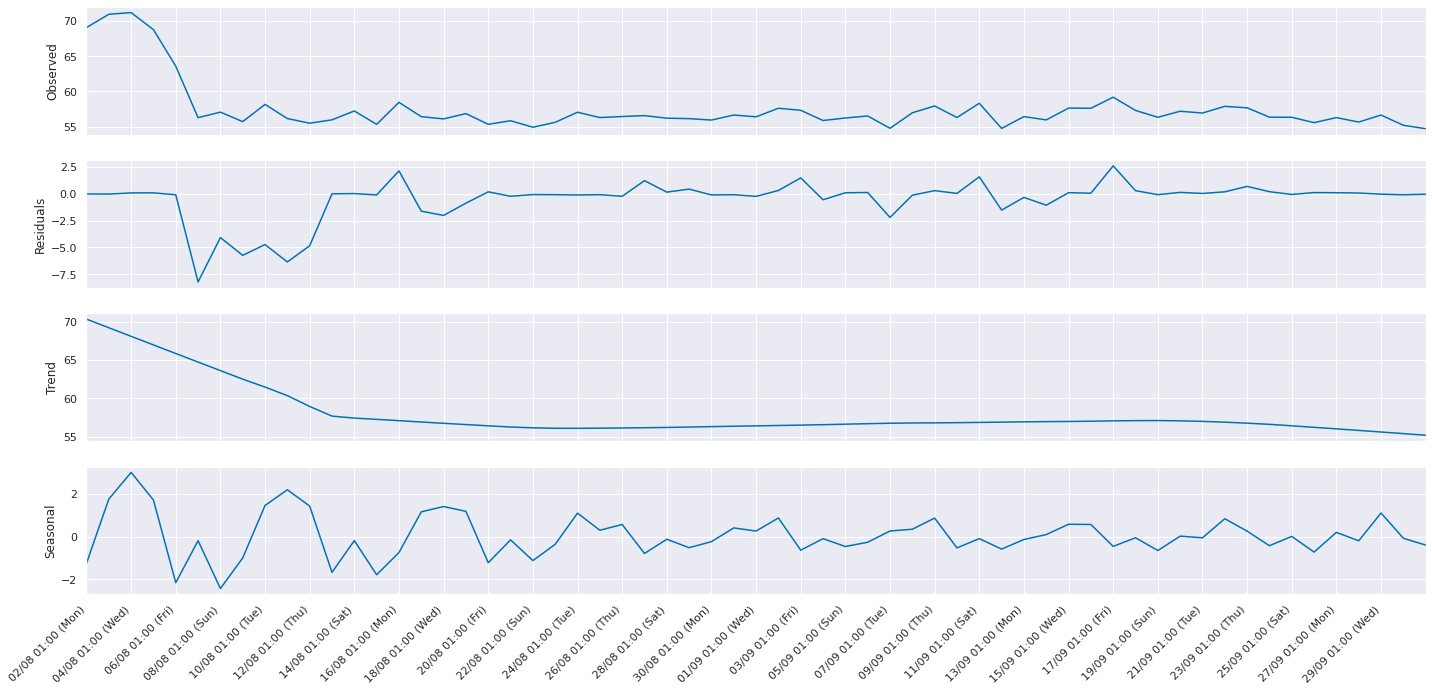

AZURE uksouth Europe/London


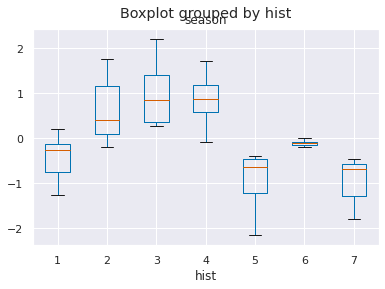

AZURE westus
H0 can not be rejected -> potentially time-dependent
----ADF Test Results----
Test Statistic       -3.1445554772242246
p Value              0.2310802650888223
used lag             7              
nobs                 53             
critical value  1%   -4.604770574433928
critical value  5%   -3.9490592323192972
critical value 10%   -3.6246202799626537
None <class 'NoneType'>


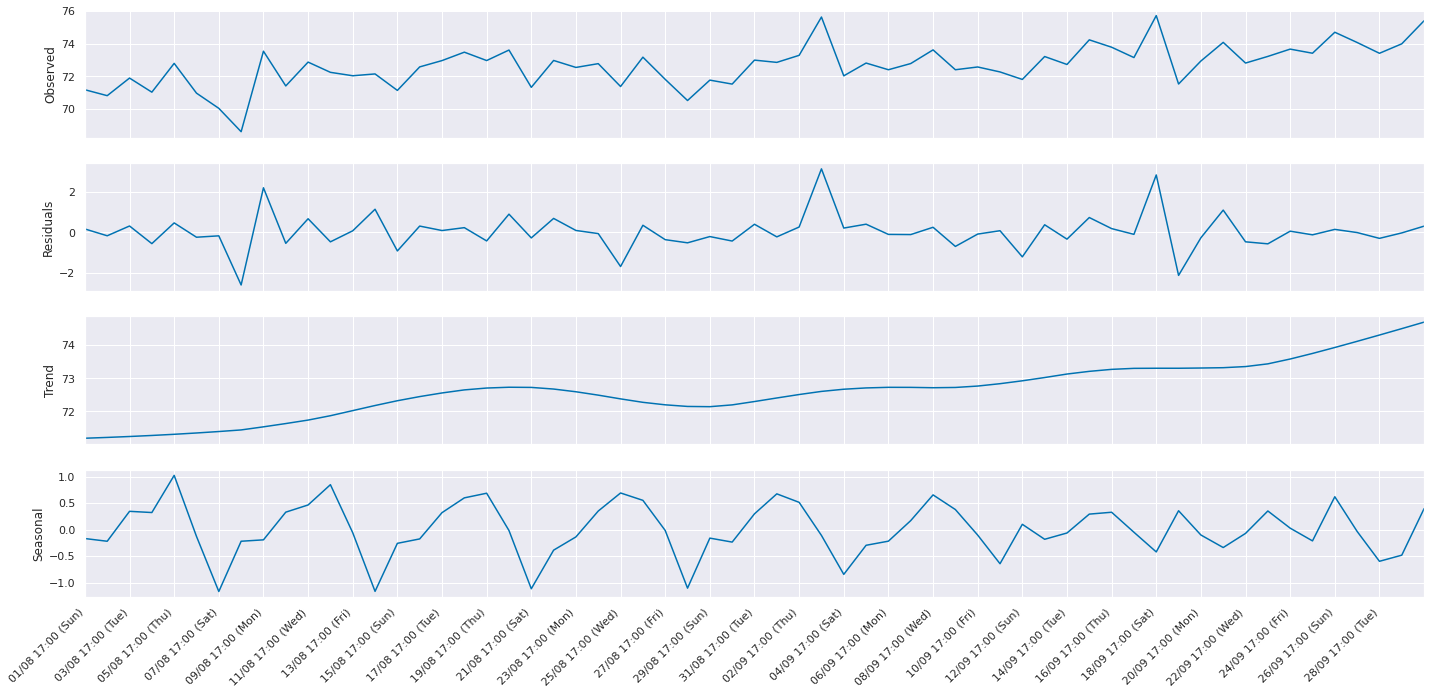

AZURE westus America/Los_Angeles


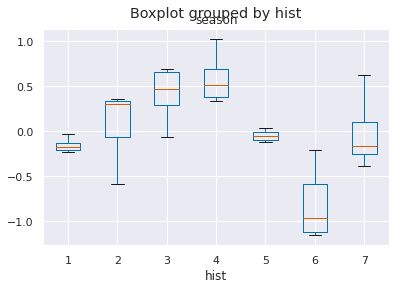

AZURE westus2
H0 can not be rejected -> potentially time-dependent
----ADF Test Results----
Test Statistic       -2.913500987833352
p Value              0.3379817130461991
used lag             7              
nobs                 53             
critical value  1%   -4.604770574433928
critical value  5%   -3.9490592323192972
critical value 10%   -3.6246202799626537
None <class 'NoneType'>


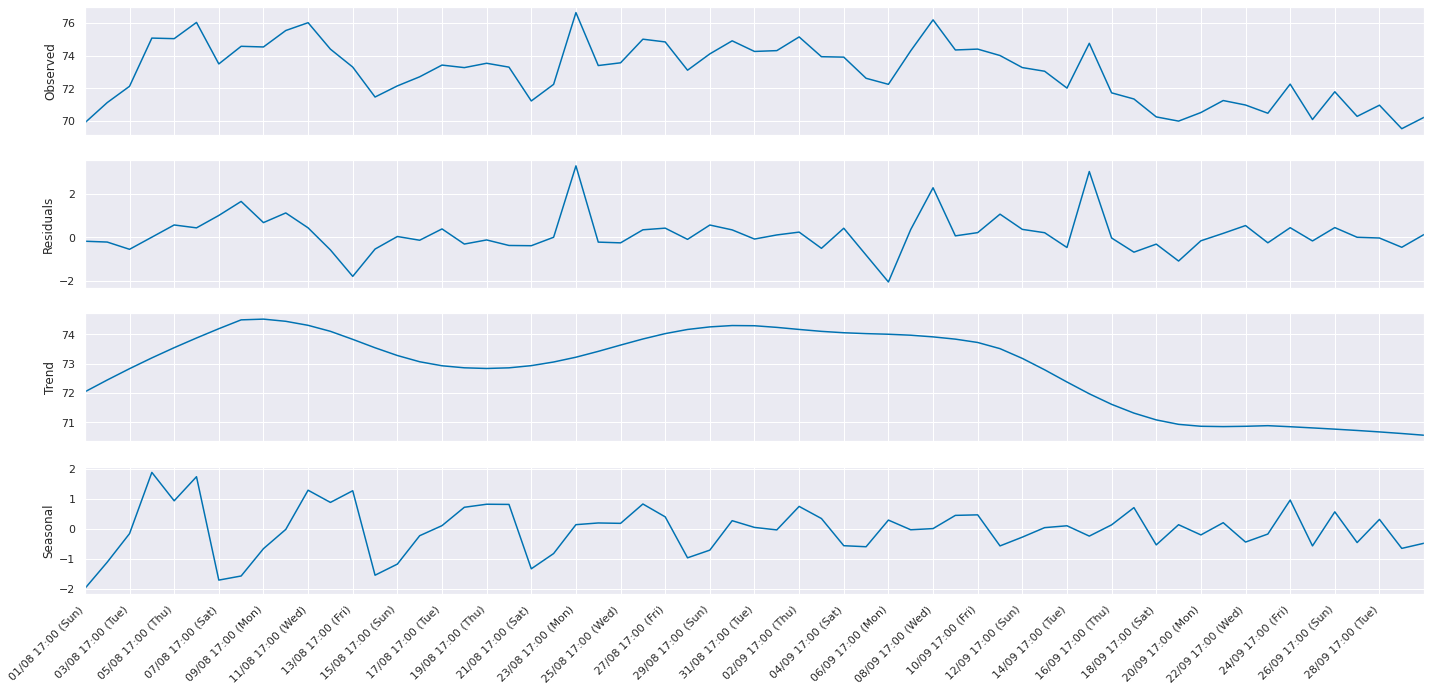

AZURE westus2 America/Los_Angeles


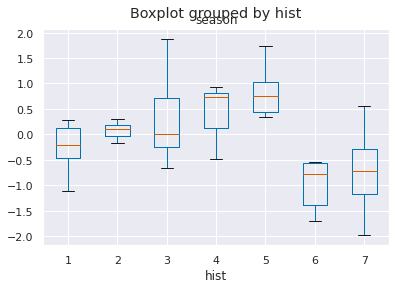

In [10]:
provider = 'AZURE' #AZURE, centralindia, eastus, germanywestcentral, japaneast, uksouth
# ['australiaeast', 'brazilsouth', 'centralindia', 'eastus', 'germanywestcentral', 'japaneast', 'uksouth', 'westus', 'westus2']
regions = ['australiaeast', 'brazilsouth', 'centralindia', 'eastus', 'germanywestcentral', 'japaneast', 'uksouth', 'westus', 'westus2']
for region in regions:
    decomp = decompose(df, provider, region, 'D', 7,
                       adflag=7,
                       #end='2021-08-14',
                       #plotstart='2021-08-03', plotend='2021-08-07',
                       adf_regression='ctt', dtfmt='%d/%m %H:%M (%a)', )#xtickstepsize=0.0421)

In [11]:
# provider = 'AZURE' #AZURE, centralindia, eastus, germanywestcentral, japaneast, uksouth
# # ['australiaeast', 'brazilsouth', 'centralindia', 'eastus', 'germanywestcentral', 'japaneast', 'uksouth', 'westus', 'westus2']
# regions = ['australiaeast', 'brazilsouth', 'centralindia', 'eastus', 'germanywestcentral', 'japaneast', 'uksouth', 'westus', 'westus2']
# for region in regions:
#     decomp = decompose(df, provider, region, 'D', 24,
#                        adflag=24,
#                        start='2021-08-01', #end='2021-08-30',
#                        adf_regression='ctt', dtfmt='%a %H', xtickstepsize=1)

In [12]:
# # Per Half-Hour
# provider = 'AZURE'
# region =  'westus2'
# decomp = decompose(df, provider, region, 'D', 24,
#                    #adflag=12,
#                    start='2021-08-01', #end='2021-08-30',
#                    adf_regression='ctt', dtfmt='%a', xtickstepsize=1)

In [13]:
# dt_rounding = "H"
# df_providerregion = df[ (df['provider'] == provider) & (df['region'] == region) ]
# df_providerregion.insert(0, "driver_invocation_rounded", df_providerregion['driver_invocation'].dt.round(dt_rounding))
# df_providerregion_runtime_mean = df_providerregion.groupby(['driver_invocation_rounded'])[['runtime']].mean()
# df_providerregion_runtime_mean_with_freq = df_providerregion_runtime_mean.asfreq(dt_rounding)

# # df_providerregion_runtime_mean.index.freq = dt_rounding

# df_providerregion_runtime_mean.shape, df_providerregion_runtime_mean_with_freq.shape
# df_providerregion_runtime_mean_with_freq.index.difference(df_providerregion_runtime_mean.index)

In [14]:
# # Per Half-Hour
# provider = 'AZURE'
# region =  'westus'
# decomp = decompose(df, provider, region, 'H', 24,
#                    #adflag=12,
#                    start='2021-08-01', end='2021-08-14',
#                    adf_regression='ctt', dtfmt='%a', xtickstepsize=1)

In [15]:
# provider = 'AZURE'
# region =  'westus'


# df_providerregion_runtime_mean.index

In [16]:
# from statsmodels.tsa.seasonal import STL
# res = STL(df_providerregion_runtime_mean).fit()
# res.plot()
# plt.show()

In [17]:
# from statsmodels.datasets import co2
# import matplotlib.pyplot as plt
# from pandas.plotting import register_matplotlib_converters
# # register_matplotlib_converters()
# data = co2.load().data
# data = data.resample('M').mean().ffill()
# data.index

In [18]:
# test1 = adfuller(decomp.observed, maxlag=24)
# print(print_adf(test1))

In [19]:
# # Hotfix - remove mean (is this ok?)
# x = decomp.observed.sub(decomp.trend,fill_value=decomp.trend.mean())
# # -> data is stationary
# test2 = adfuller(x, maxlag=24)
# print_adf(test2)

In [20]:
# # Hotfix - remove mean (is this ok?)
# x = decomp.observed.sub(decomp.trend,fill_value=decomp.trend.mean()).sub(decomp.seasonal)
# plt.plot(x)
# test3 = adfuller(x, maxlag=24)
# # -> data is stationary
# test3

In [21]:
# # TODO: https://www.machinelearningplus.com/time-series/augmented-dickey-fuller-test/

# # Hourly
# decompose(df, provider, region, 'H', 24)
# decompose(df, provider, region, 'T', 48, adflag=12)

In [22]:
# # Daily
# #decompose(df, provider, region, 'D', 7)
# decompose(df, provider, region, 'D', 7, xtickstepsize=1)

In [23]:
# # Daily
# decompose(df, provider, region, '7D', 4)

In [24]:
# Examples
# result = decompose(df, 'AZURE', 'japaneast', dtfmt='%d/%m', xtickstepsize=2)
# result = decompose(df, 'AZURE', 'japaneast', start='2021-08-29', end='2021-09-7', dtfmt='%a %d/%m %H:%M', xtickstepsize=0.4)
# result = decompose(df, 'GCP', 'us-west4', start='2021-08-01', end='2021-08-07', dtfmt='%a %d/%m %H:%M', xtickstepsize=0.4)

In [25]:
# TODO: Make the default?

# for index, row in df.groupby( ['provider', 'region'], observed=True)['measure group'].unique().reset_index().iterrows():
#     provider = row['provider']
#     region = row['region']
#     print('-'*50)
#     print(provider, region)
#     print('half hourly')
#     # decompose(df, provider, region, 'T', 48)
#     print('hourly')
#     decomp_hourly = decompose(df, provider, region, 'H', 24)
    
#     print('-'*5)
    
#     print('daily')
#     decomp_daily = decompose(df, provider, region, 'D', 7)
#     print('-'*50)

In [26]:
# print(decomp_daily.observed)

In [27]:
# from dateutil import rrule
# from datetime import datetime, timedelta

# # Generate Weekly 'Cut Outs' for plotting (but decompose on entire data)
# # TODO: Optimize per provider and then plot different slices.
# startdate = datetime.strptime('2021-08-01', '%Y-%m-%d')
# # enddate = datetime.strptime('2021-10-3', '%Y-%m-%d')
# enddate = datetime.strptime('2021-8-16', '%Y-%m-%d')

# for index, row in df.groupby( ['provider', 'region'], observed=True)['measure group'].unique().reset_index().iterrows():
#     provider = row['provider']
#     region = row['region']
#     rruleSeries = rrule.rrule(rrule.WEEKLY, dtstart=startdate, until=enddate)
    
#     print(provider, region)
    
#     # Decompose
#     dataset = df
#     timezone = get_timezone(df, provider, region)
#     df_providerregion = dataset[ (dataset['provider'] == provider) & (dataset['region'] == region) ]
#     df_providerregion.insert(0, "driver_invocation_rounded", df_providerregion['driver_invocation'].dt.round('7D'))
    
#     df_providerregion_runtime_mean = df_providerregion.groupby(['driver_invocation_rounded'])[['runtime']].mean()
#     test = adfuller(df_providerregion_runtime_mean['runtime'], autolag='AIC')
#     dfdecomp = seasonal_decompose(df_providerregion_runtime_mean, model='addtive' , period=48)
    
#     for dt in rruleSeries:
#         start = dt.strftime('%Y-%m-%d')
#         after = rruleSeries.after(dt)
#         # Only print if after date can be generated
#         if after is not None:
#             end = after.strftime('%Y-%m-%d')
#             print('-'*50)
#             print(start, end)
#             plot_decompose(dfdecomp, timezone, start=start, end=end, dtfmt='%a %d/%m %H:%M', xtickstepsize=0.4)
        
#     print(print_adf(test))
#     print('-'*50)